In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/Users/geenaildefonso/Projects/")
import mazebox as mb
sys.path.insert(1, '/Users/geenaildefonso/Dropbox (VU Basic Sciences)/')
from typing import Any
from copy import copy
from anndata import AnnData
import scipy.sparse as sp
from cellrank.tl.kernels import VelocityKernel
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
adata = scv.read('/Users/geenaildefonso/Dropbox (VU Basic Sciences)/RPM/adata_03bwvl.h5ad') #This is the adata with velocity calculated already

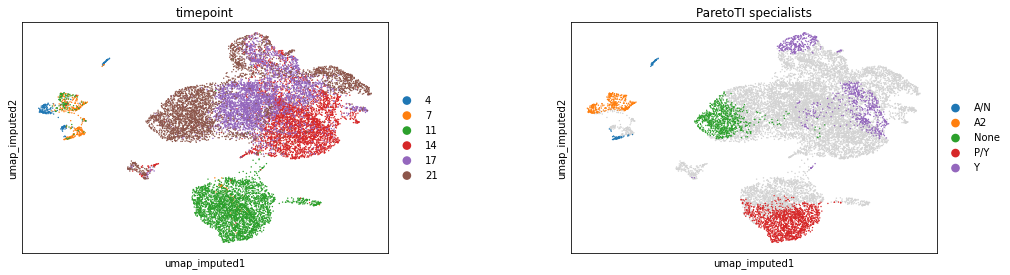

In [3]:
sc.pl.scatter(adata, basis = 'umap_imputed', color = ['timepoint','ParetoTI_specialists']) #make sure umaps look correct before moving forward for timepoints and archetypes

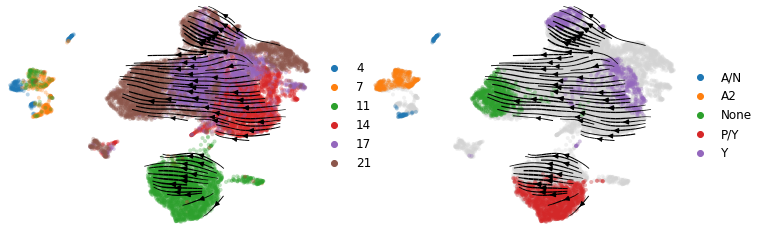

In [4]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap_imputed", color = ['timepoint', 'ParetoTI_specialists'], legend_fontsize=12, title="", smooth=0.8, min_mass=4, legend_loc = 'on right')

In [5]:
class MyKernel(cr.tl.kernels.Kernel):
    def __init__(
        self, adata: AnnData, obs_key: str = "Diffusion Pseudotime", **kwargs: Any
    ):
        super().__init__(adata=adata, obs_key=obs_key, **kwargs)

    def _read_from_adata(self, obs_key: str, **kwargs: Any) -> None:
        super()._read_from_adata(**kwargs)

        print(f"Reading `adata.obs[{obs_key!r}]`")
        self.pseudotime = self.adata.obs[obs_key].values

    def compute_transition_matrix(self, some_parameter: float = 0.5) -> "MyKernel":
        print("Accessing `.pseudotime`: ", self.pseudotime)
        transition_matrix = sp.diags(
            (some_parameter,) * len(self.adata), dtype=np.float64
        )

        self._compute_transition_matrix(transition_matrix)

        return self

    def copy(self) -> "MyKernel":
        return copy(self)

In [6]:
k = MyKernel(adata).compute_transition_matrix()
k.compute_transition_matrix()

Reading `adata.obs['Diffusion Pseudotime']`
Accessing `.pseudotime`:  [0.08062416 0.07080161 0.0694875  ... 0.13437028 0.12651777 0.10692273]
Accessing `.pseudotime`:  [0.08062416 0.07080161 0.0694875  ... 0.13437028 0.12651777 0.10692273]


<MyKernel>

In [7]:
vk = VelocityKernel(adata)
vk.compute_transition_matrix()

  0%|          | 0/15138 [00:00<?, ?cell/s]

  0%|          | 0/15138 [00:00<?, ?cell/s]

<VelocityKernel>

In [8]:
combined_kernel = 0.45 * vk + 0.55* k

In [9]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[n=15138, kernel=((0.45 * <VelocityKernel[softmax_scale=6.5, mode=deterministic, seed=2732, scheme=<CorrelationScheme>]>) + (0.55 * <MyKernel>))]


In [10]:
g.compute_schur(n_components=20)

Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999756e-01 -1.4965675452787986e-04 1.2242807691380446e-03 -3.7584816366833941e-03 -1.6625594365638271e-03 -4.0589334320083326e-03 2.8297623549878155e-04 2.6865187134998209e-02 -1.3721073523471879e-02 2.2972430143242163e-02 1.2366640858173012e-02 6.8672322480053793e-03 1.7297877683230364e-02 1.0353674391985474e-02 -3.3702733054245459e-03 -5.5352284381802296e-03 1.0595606897406067e-02 1.8185049695167325e-02 -3.4073013290017370e-02 1.4947538641159065e-02 1.1693810674479865e-02 
0.0000000000000000e+00 9.9906198702075921e-01 3.9130122739775625e-05 2.5569773635432916e-03 5.0990546755719070e-03 -3.2582953000929848e-06 -1.4436371182705821e-03 1.3305227186922682e-02 1.5758786494891456e-03 9.9678827851134473e-03 8.4414686534966133e-03 2.6926136413782564e-03 3.8195889778418739e-03 3.5870895047408289e-03 -5.0323995278324729e-03 -2.1571976835020002e-03 -1.1371681610785403e-02 1.5584043424329399e-02 -3.4943726878724781e-03 7.2199232673749716e-

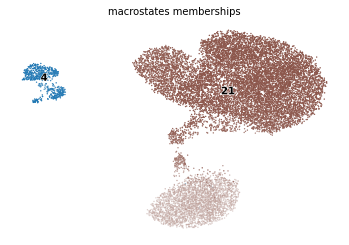

In [20]:
g.compute_macrostates(cluster_key="timepoint") 
g.plot_macrostates()

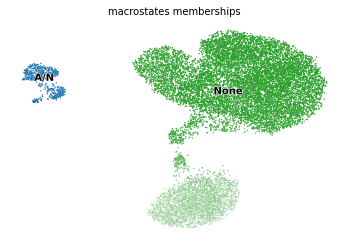

In [29]:
g.compute_macrostates(cluster_key="ParetoTI_specialists") #to change macrostates calcualted by archetype
g.plot_macrostates()

In [30]:
g.compute_terminal_states() 

In [31]:
g.compute_absorption_probabilities(solver="gmres", use_petsc=True)

  0%|          | 0/2 [00:00<?, ?/s]

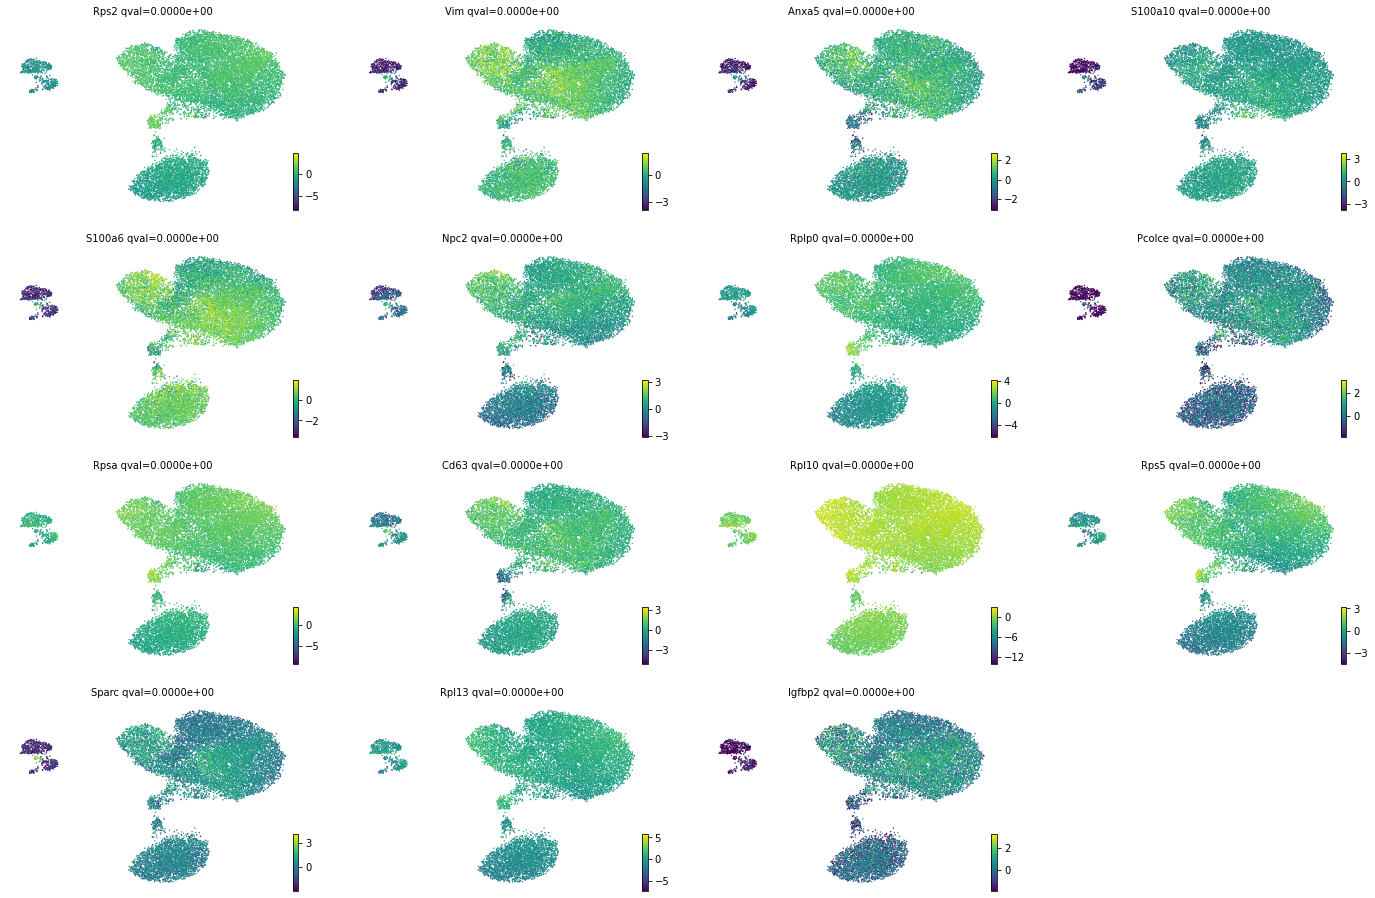

In [24]:
day21_drivers = g.compute_lineage_drivers(lineages="21", return_drivers=True)  #when running macrostates and terminal states by timepoint
day21_drivers.sort_values(by="21_corr", ascending=False)
g.plot_lineage_drivers("21", n_genes=15)

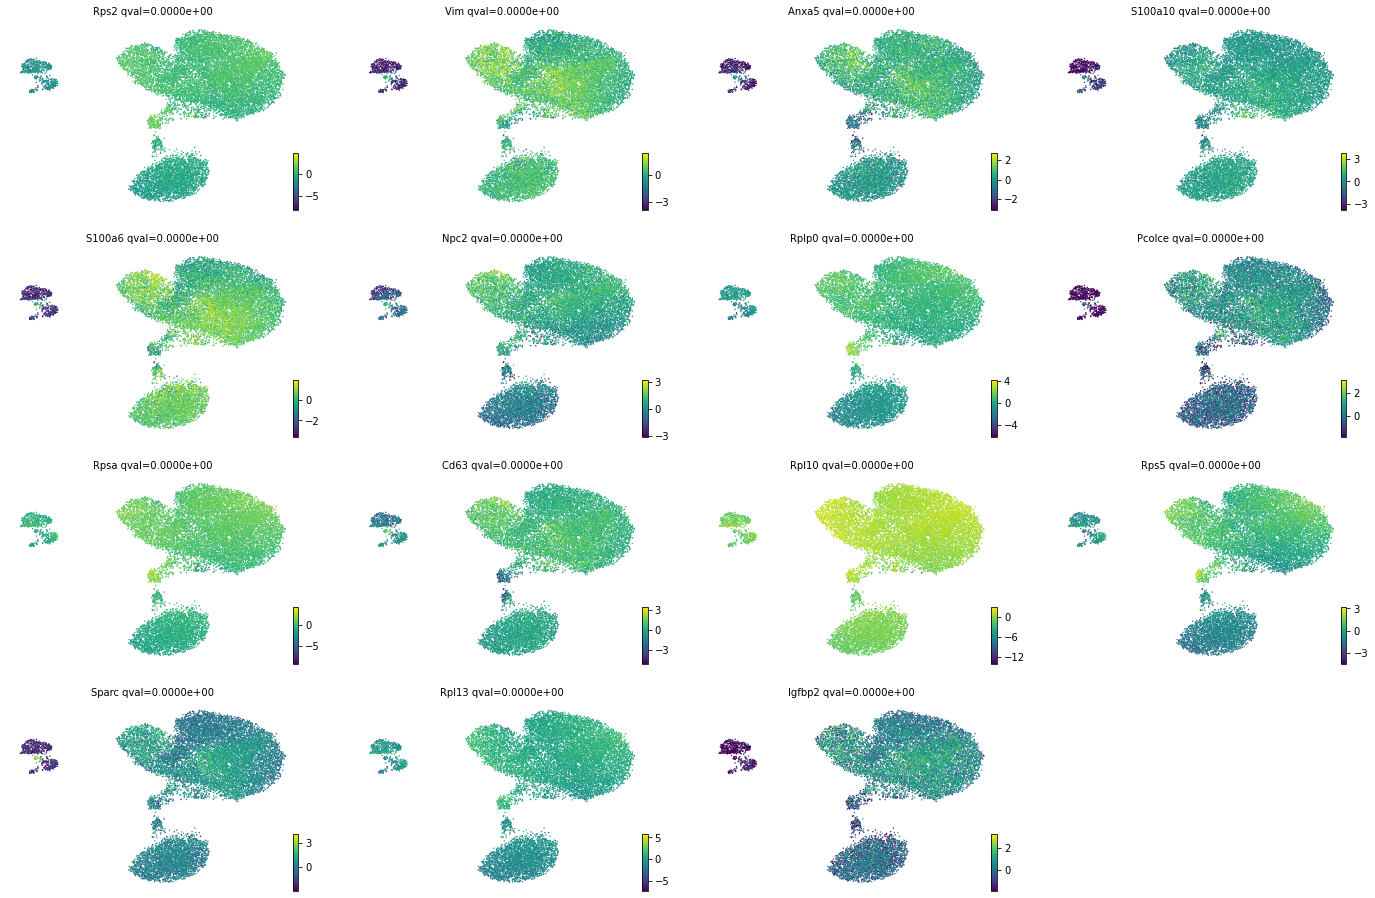

In [32]:
dayterm_drivers = g.compute_lineage_drivers(lineages="None", return_drivers=True) #when running macrostates and terminal states by archetype
dayterm_drivers.sort_values(by="None_corr", ascending=False)
g.plot_lineage_drivers("None", n_genes=15)

In [33]:
scv.tl.paga(
    adata,
    groups="timepoint",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="Diffusion Pseudotime",
)

running PAGA using priors: ['Diffusion Pseudotime', 'terminal_states_probs']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


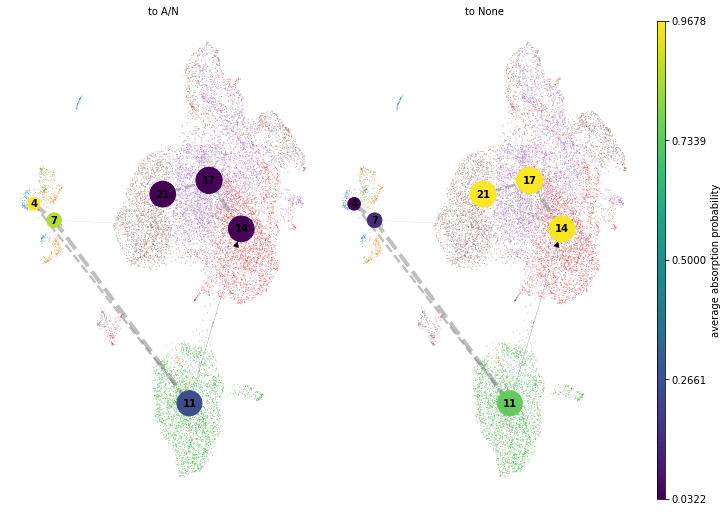

In [34]:
cr.pl.cluster_fates(
    adata,
    mode="paga",
    cluster_key="timepoint",
    basis="umap_imputed",
    legend_kwargs={"loc": "top right out"},
    legend_loc="on data",
    node_size_scale=4,
    edge_width_scale=1,
    max_edge_width=4,
    title="Directed PAGA",figsize = (10, 7))#, save = 'paga_timepoint.pdf')

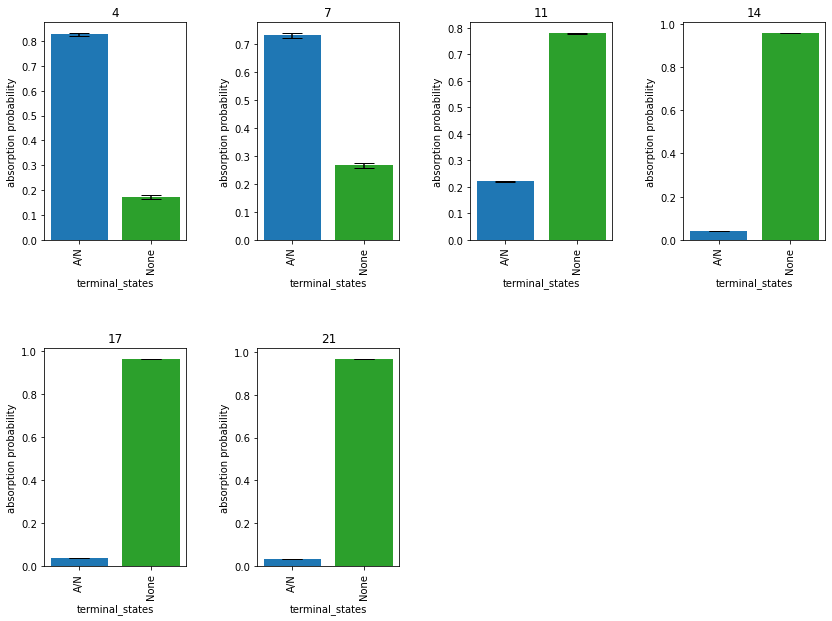

In [35]:
cr.pl.cluster_fates(
    adata,
    mode="bar",
    cluster_key="timepoint",
    basis="umap_imputed") #, save = 'paga_bar_timepoint.pdf'


In [36]:
cr.tl.terminal_states(
    adata,
    cluster_key="timepoint",
    weight_connectivities=0.2,
    n_states=3,
    softmax_scale=4,
    show_progress_bar=False,
)
cr.tl.lineages(adata)

model = cr.ul.models.GAM(adata,link='log')

/var/folders/mk/5gzhv5l57n56d6x7fnfgzpw00000gn/T/ipykernel_87175/3862868937.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(
/Users/geenaildefonso/anaconda/envs/mazebox_env/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000109e+00 -1.9308237079132395e-06 -4.3863340785895823e-03 6.3706638286082154e-04 
0.0000000000000000e+00 9.9706782279266981e-01 -2.3387999683174617e-03 7.6935846144338374e-05 
0.0000000000000000e+00 0.0000000000000000e+00 9.8775557094772948e-01 6.9801217739435227e-04 
0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 9.7972310718255529e-01 
0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 


/var/folders/mk/5gzhv5l57n56d6x7fnfgzpw00000gn/T/ipykernel_87175/3862868937.py:9: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)


  0%|          | 0/3 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?gene/s]

/Users/geenaildefonso/anaconda/envs/mazebox_env/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/geenaildefonso/anaconda/envs/mazebox_env/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pr

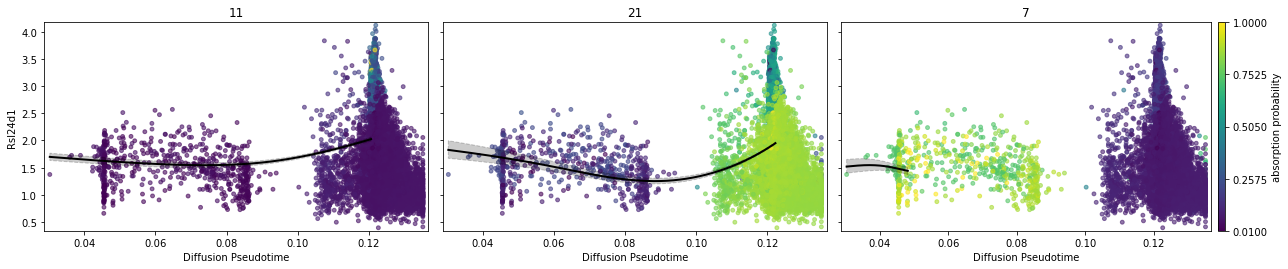

In [37]:
cr.pl.gene_trends(
    adata,
    model,
    ["Rsl24d1"],
    data_key="Ms",
    time_key="Diffusion Pseudotime",
    show_progress_bar=False,
)

In [38]:
genes = cr.pl.heatmap(
    adata,
    model,
    adata.var_names[:15],
    time_key="Diffusion Pseudotime",
    lineages="21",
    show_absorption_probabilities=True,
    show_progress_bar=False,
    return_genes=True,
)
genes

  0%|          | 0/15 [00:00<?, ?gene/s]

RuntimeError: Fatal model failure `<FailedModel[origin=GAM[gene='CAAA01118383.1', lineage='21', model=GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, max_iter=2000, scale=None, terms=s(0), tol=0.0001, verbose=False)]]>`.